In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import numpy as onp

import paragami

import matplotlib.pyplot as plt
%matplotlib inline

from bnpmodeling_runjingdev import log_phi_lib, cluster_quantities_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.exponential_families as ef

from structure_vb_lib import structure_model_lib, plotting_utils
from structure_vb_lib import structure_optimization_lib as s_optim_lib
from structure_vb_lib.data_utils import cluster_admix_get_indx

import re


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
# scratch_dir = '/scratch/users/genomic_times_series_bnp/structure/' # scratch directory
# out_folder = scratch_dir + 'hgdp_fits/' # folder where fits are found
# out_filename = 'huang2011_fit' # name of fit

data_file='../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.bed'
out_filename='huang2011_fit'
out_folder='../fits/hgdp_fits/'

In [4]:
# initial fit and linear response derivatives
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
lr_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# check paths exist
assert os.path.isfile(init_fit_file)
assert os.path.isfile(lr_file)

# Load initial fit and meta data

In [5]:
print('initial fit file: ', init_fit_file)

vb_opt_dict, vb_params_paragami, \
        prior_params_dict, prior_params_paragami, \
            gh_loc, gh_weights, init_fit_meta_data = \
                structure_model_lib.load_structure_fit(init_fit_file)

alpha0 = prior_params_dict['dp_prior_alpha']

# the initial free parameters
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

print('Init optim time: {:.3f}secs'.format(init_fit_meta_data['optim_time']))

initial fit file:  ../fits/hgdp_fits/huang2011_fit_alpha6.0.npz
Init optim time: 4580.959secs


`vb_opt_dict` contains the parameters at the initial ($\epsilon = 0)$ fit. 

The parameter dictionary contains two keys: 
- `pop_freq_beta_params`: a (`n_loci` x `k_approx` x 2) array of Beta parameters that describe the approximate posterior on population allele frequencies. (these are the "cluster centroids").
- `ind_admix_params`: contain the logit-normal parameters on the stick-breaking proportions. This is yet another dictionary with two keys, `stick_means` and `stick_infos`. Each are (`n_obs` x `k_approx - 1`). 

In [6]:
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (2810, 20, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (1107, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (1107, 19) (lb=0.0, ub=inf)


The `ind_admix_params` are of particular importance, as they define inferred admixture proportions. 

The expected individual mixture proportions is an array of shape `n_obs x k_approx`, where the $(n,k)$-th entry is the posterior probability of individual $n$ belonging to cluster $k$. 

In [7]:
def get_e_ind_admix(vb_free_params): 
    
    # this returns the expected individual mixture proportions. 
        
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    
    return e_ind_admix
    


In [8]:
e_ind_admix0 = get_e_ind_admix(vb_opt)

print(e_ind_admix0.shape)

(1107, 20)


In [9]:
# # plot expected mixture proportions

# fig, ax = plt.subplots(1, 1, figsize = (6, 3))

# # top 6 clusters are colored ... remaining clusters are grey
# # height of bar represents mixture proportions
# plotting_utils.plot_top_clusters(e_ind_admix0, ax, n_top_clusters = 6); 

# Define perturbation

This class contains a collection of perturbations. 

In [23]:
f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami, 
                                            prior_params_dict['dp_prior_alpha'],
                                            gh_loc, 
                                            gh_weights,
                                            stick_key = 'ind_admix_params')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 199

Choose a perturbation. Available perturbations are: 

- 'worst-case', the worst-case L-inf perturbation
- 'sigmoidal', the perturbation where log-phi is a sigmoid function
- 'sigmoidal_neg', the perturbation where log-phi is the negative sigmoid function
- 'alpha_pert_pos', the multiplicative functional perturbation to move the DP alpha parameter by +5
- 'alpha_pert_neg', the multiplicative functional perturbation to move the DP alpha parameter by -5
- 'alpha_pert_pos_xflip', same as alpha_pert_pos but reflected about x = 0
- 'alpha_pert_neg_xflip', same as alpha_pert_neg but reflected about x = 0
- 'gauss_pert1_pos', a positive gaussian bump at logit_v = 0
- 'gauss_pert2_pos', a positive gaussian bump at logit_v = -3
- 'gauss_pert1_neg', a negative gaussian bump at logit_v = 0
- 'gauss_pert2_neg', a negative gaussian bump at logit_v = -3

In [11]:
# choose a perturbation
perturbation = 'worst_case'
f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)

AttributeError: 'LogPhiPerturbations' object has no attribute 'f_obj_worst_case'

`f_obj` contains a few important methods for fitting and computing the linear response. For this notebook, the important one (really just for plotting) is the `log_phi` method, which returns log multiplicative perturbation. 

(other methods include expecations of log-phi). 

In [12]:
log_phi = f_obj.log_phi

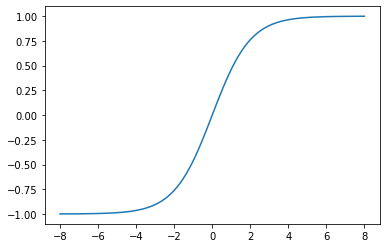

In [13]:
# The log-phi
# (we will plot the effect on the prior later)
logit_v_grid = np.linspace(-8, 8, 100)
plt.plot(logit_v_grid, log_phi(logit_v_grid))

# Define linear sensitivity

In [12]:
print('loading derivatives from: ', lr_file)
lr_data = np.load(lr_file)

# check some stuff: make sure it matches the intial fit
assert lr_data['alpha0'] == alpha0 # check alphas match
assert np.abs(lr_data['vb_opt'] - vb_opt).max() < 1e-12 # check optimum match
assert np.abs(lr_data['kl'] - init_fit_meta_data['final_kl']) < 1e-8 # check KL's match

loading derivatives from:  ../fits/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz


In [13]:
dinput_dfun = lr_data['dinput_dfun_' + perturbation]

In [14]:
print('Derivative time: {:.02f} secs'.format(lr_data['lr_time_' + perturbation]))
print('CG tolerance: ', lr_data['cg_tol'])

Derivative time: 525.92 secs
CG tolerance:  0.01


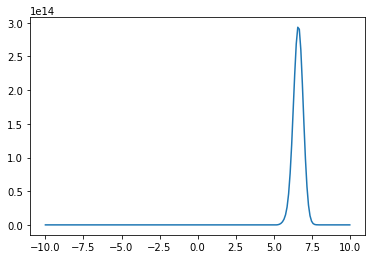

In [24]:
plt.plot(lr_data['logit_v_grid'], 
         lr_data['influence_grid'])

# Load refits

In [17]:
match_crit = out_filename + '_' + perturbation + '\d+.npz'
refit_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    
assert len(refit_files) > 0, 'no refit files found'

In [18]:
def load_refit_files(refit_files): 
    
    # load files
    optim_time_vec = [init_fit_meta_data['optim_time']]
    epsilon_vec = [0.]
    vb_refit_list = [vb_opt]
    delta = []
    
    for i in range(len(refit_files)): 

        print('loading fit from: ', refit_files[i])
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(out_folder + refit_files[i])
        
        vb_free = vb_params_paragami.flatten(vb_params_dict, free = True)
                
        # save the metadata we need
        optim_time_vec.append(meta_data['optim_time'])
        epsilon_vec.append(meta_data['epsilon'])
        vb_refit_list.append(vb_free)
        
        # for the sigmoidal perturbation, we scaled the original function 
        # by a factor delta.
        # Save this delta
        delta.append(meta_data['delta'])
        
    optim_time_vec = np.array(optim_time_vec)
    epsilon_vec = np.array(epsilon_vec)
    vb_refit_list = np.array(vb_refit_list)
    
    # all the delta's should be the same ... 
    delta = np.unique(np.array(delta))
    print('delta = ', delta)
    assert len(delta) == 1
    
    # sort the epsilons 
    _indx = np.argsort(epsilon_vec)
    optim_time_vec = optim_time_vec[_indx]
    epsilon_vec = epsilon_vec[_indx]
    vb_refit_list = vb_refit_list[_indx]
    
    return vb_refit_list, epsilon_vec, optim_time_vec, delta

In [19]:
vb_refit_list, epsilon_vec, optim_time_vec, delta = \
    load_refit_files(refit_files)

loading fit from:  huang2011_fit_sigmoidal12.npz
loading fit from:  huang2011_fit_sigmoidal15.npz
loading fit from:  huang2011_fit_sigmoidal8.npz
loading fit from:  huang2011_fit_sigmoidal1.npz
loading fit from:  huang2011_fit_sigmoidal6.npz
loading fit from:  huang2011_fit_sigmoidal7.npz
loading fit from:  huang2011_fit_sigmoidal0.npz
loading fit from:  huang2011_fit_sigmoidal9.npz
loading fit from:  huang2011_fit_sigmoidal14.npz
loading fit from:  huang2011_fit_sigmoidal13.npz
loading fit from:  huang2011_fit_sigmoidal3.npz
loading fit from:  huang2011_fit_sigmoidal4.npz
loading fit from:  huang2011_fit_sigmoidal10.npz
loading fit from:  huang2011_fit_sigmoidal17.npz
loading fit from:  huang2011_fit_sigmoidal18.npz
loading fit from:  huang2011_fit_sigmoidal16.npz
loading fit from:  huang2011_fit_sigmoidal11.npz
loading fit from:  huang2011_fit_sigmoidal5.npz
loading fit from:  huang2011_fit_sigmoidal2.npz
delta =  [5.]


`vb_refit_list` contains the free parameters from each refit. 

`vb_refit_list[i]` corresponds to the refit with `epsilon = epsilon_vec[i]`. 

# Get linear approximation to the refits

In [20]:
def predict_opt_par_from_hyper_par(epsilon): 
    return vb_opt + dinput_dfun * epsilon * delta

lr_list = []
for epsilon in epsilon_vec: 
    # get linear response
    lr_list.append(predict_opt_par_from_hyper_par(epsilon))


`lr_list` contains the free parameters from the linear approximation. 

`lr_list[i]` corresponds to the predicted free parameters for `epsilon = epsilon_vec[i]`. 

# Plot priors 

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.388126e-08
  warnings.warn(


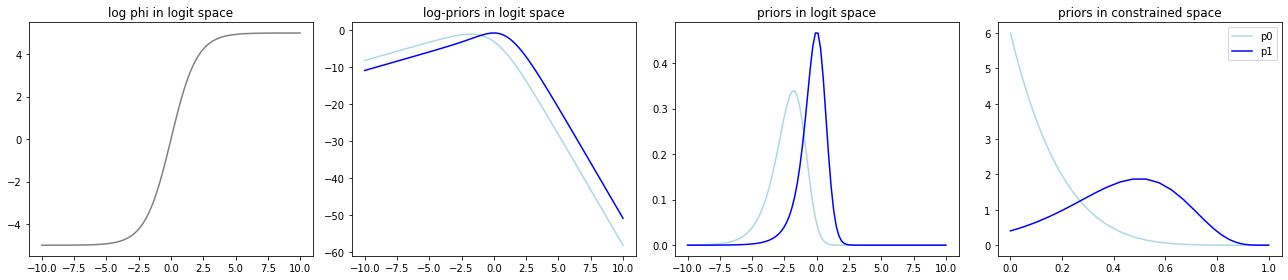

In [21]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = lambda x : f_obj.log_phi(x) * delta, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)

prior_perturbation.plot_perturbation();

# Plot vb free parameters

In [22]:
def print_diff_plot(x, y, x0, ax, color = 'red', alpha = 1.): 
    ax.plot(x - x0, y - x0, '+', color = color, alpha = alpha)
    ax.plot(x - x0, x - x0, '-', color = 'blue', alpha = alpha)

In [23]:
def plot_params_diff_plot(refit_free_params, lr_free_params, init_free_params): 
    
    # store the free parameters into dictionaries
    # free = False means that we are plotting the free parameters (we don't constrain them)
    init_free_param_dict = vb_params_paragami.fold(init_free_params, free = False)
    lr_free_param_dict = vb_params_paragami.fold(lr_free_params, free = False)
    refit_free_param_dict = vb_params_paragami.fold(refit_free_params, free = False)
    
    fig, ax = plt.subplots(1, 3, figsize = (12, 3))

    ax[0].set_title('pop freq. parameters')
    print_diff_plot(lr_free_param_dict['pop_freq_beta_params'].flatten(),
                    refit_free_param_dict['pop_freq_beta_params'].flatten(), 
                    init_free_param_dict['pop_freq_beta_params'].flatten(), 
                    ax[0])


    ax[1].set_title('stick means')
    print_diff_plot(lr_free_param_dict['ind_admix_params']['stick_means'].flatten(),
                    refit_free_param_dict['ind_admix_params']['stick_means'].flatten(), 
                    init_free_param_dict['ind_admix_params']['stick_means'].flatten(), 
                    ax[1])

    ax[2].set_title('stick infos')
    print_diff_plot(lr_free_param_dict['ind_admix_params']['stick_infos'].flatten(),
                    refit_free_param_dict['ind_admix_params']['stick_infos'].flatten(), 
                    init_free_param_dict['ind_admix_params']['stick_infos'].flatten(), 
                    ax[2])
    
    for i in range(3): 
        ax[i].set_xlabel('lr - init')
        ax[i].set_ylabel('refit - init')
        
    fig.tight_layout()

### At smallest epsilon

In [24]:
# the smallest epsilon
epsilon_vec[1]

DeviceArray(0.00277008, dtype=float64)

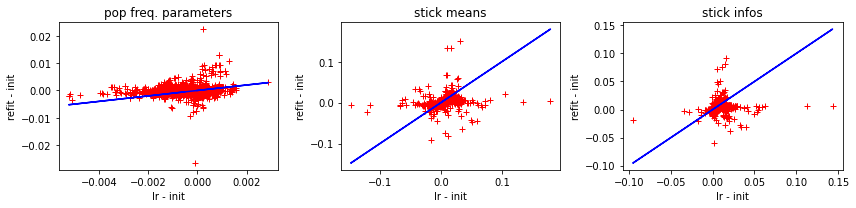

In [25]:
plot_params_diff_plot(vb_refit_list[1], lr_list[1], vb_refit_list[0])

### at epsilon = 1

In [26]:
# if all the refits completed, 
# last epsilon shoudl be epsilon = 1
epsilon_vec[-1]

DeviceArray(1., dtype=float64)

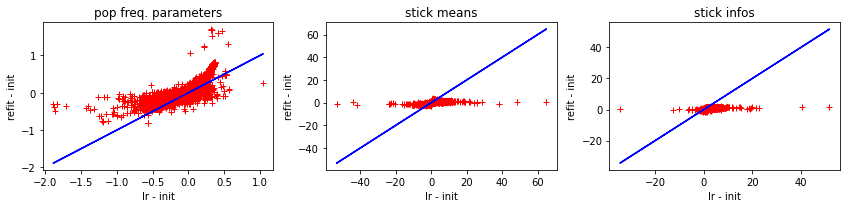

In [27]:
plot_params_diff_plot(vb_refit_list[-1], lr_list[-1], vb_refit_list[0])

# Expected number of clusters

In [28]:
def get_e_num_clusters(vb_free_params): 

    # get expected mixture proportions
    e_ind_admix = get_e_ind_admix(vb_free_params)
    
    # get number of clusters from expected mixture proportions
    e_ind_admix = e_ind_admix
    return cluster_quantities_lib.get_e_num_clusters_from_ez(e_ind_admix)

In [29]:
def get_all_stats(param_list, get_stat): 
    
    stat_vec = []
    
    for i in range(len(param_list)): 
        stat_vec.append(get_stat(param_list[i]))
        
    return np.array(stat_vec)

In [30]:
refit_color = '#d95f02'
lr_color = '#1b9e77'

Text(0, 0.5, 'Expected n. clusters')

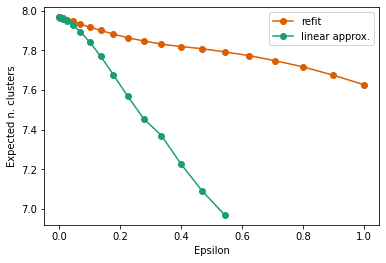

In [31]:
refit_e_num_clusters_vec = get_all_stats(vb_refit_list, get_e_num_clusters)
lr_e_num_clusters_vec = get_all_stats(lr_list, get_e_num_clusters)
    
# plot
plt.plot(epsilon_vec, 
         refit_e_num_clusters_vec, 
         'o-', 
         color = refit_color, 
         label = 'refit')

plt.plot(epsilon_vec,
         lr_e_num_clusters_vec, 
         'o-',
         color = lr_color, 
         label = 'linear approx.')

plt.legend()

plt.xlabel('Epsilon')
plt.ylabel('Expected n. clusters')

# Plot inferred admixtures

In [32]:
n_obs = e_ind_admix0.shape[0]
k_approx = e_ind_admix0.shape[1] 

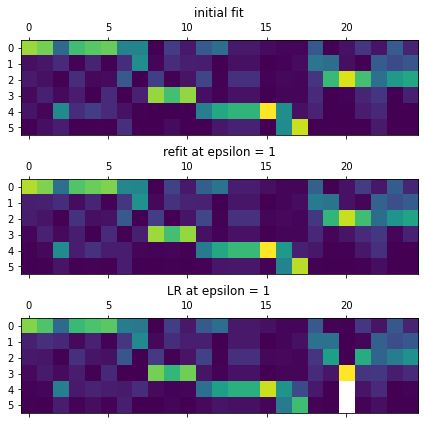

In [33]:
# plot expected mixture proportions

fig, ax = plt.subplots(3, 1, figsize = (6, 6))

# if full data, subsample 
if n_obs > 25: 
    n_indx = onp.random.choice(n_obs, 25)
    n_indx = np.sort(n_indx)
else: 
    n_indx = np.arange(25)

# plot first k_sub clusters
k_sub = 6
ax[0].set_title('initial fit')
ax[0].matshow(e_ind_admix0[n_indx, 0:k_sub].transpose())

ax[1].set_title('refit at epsilon = 1')
e_ind_admix_refit = get_e_ind_admix(vb_refit_list[-1])
ax[1].matshow(e_ind_admix_refit[n_indx, 0:k_sub].transpose())

ax[2].set_title('LR at epsilon = 1')
e_ind_admix_lr = get_e_ind_admix(lr_list[-1])
ax[2].matshow(e_ind_admix_lr[n_indx, 0:k_sub].transpose())

fig.tight_layout()


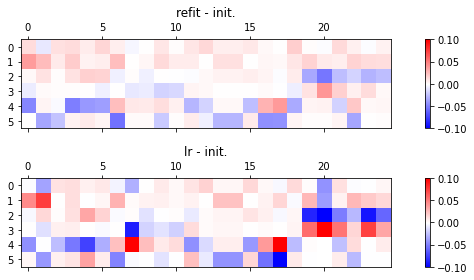

In [34]:
fig, ax = plt.subplots(2, 1, figsize = (10, 4))

vmax = 0.1

ax[0].set_title('refit - init.')
ax0 = ax[0].matshow((e_ind_admix_refit - e_ind_admix0)[n_indx, 0:k_sub].transpose(),
              vmax = vmax, 
              vmin = -vmax, 
              cmap = plt.get_cmap('bwr'))

ax[1].set_title('lr - init.')
ax1 = ax[1].matshow((e_ind_admix_lr - e_ind_admix0)[n_indx, 0:k_sub].transpose(), 
              vmax = vmax, 
              vmin = -vmax, 
              cmap = plt.get_cmap('bwr'))


fig.colorbar(ax0, ax = ax[0])
fig.colorbar(ax1, ax = ax[1])

fig.tight_layout()


### Trace plots for some subsampled individuals

In [35]:
def make_admix_trace_plots(stick_fun, n_indx, k_indx, ylab = ''): 
    # stick_fun is a function that takes in vb_free parameters 
    # and returns a n_obs x k_approx array of summary statistics 
    # (e.g. stick means or mixture proportions)
    
    lr_array = get_all_stats(lr_list, stick_fun)
    refit_array = get_all_stats(vb_refit_list, stick_fun)

    for n in n_indx: 
        fig, ax = plt.subplots(1, len(k_indx), figsize = (18, 3))

        for k in range(len(k_indx)): 
            
            ax[k].plot(epsilon_vec, 
                       lr_array[:, n, k_indx[k]], 
                       '-x',
                       color = lr_color,
                       label = 'lr')
            
            ax[k].plot(epsilon_vec, 
                       refit_array[:, n, k_indx[k]], 
                       '-x', 
                       color = refit_color, 
                       label = 'refit')
            
            ax[k].set_title('n = {}; k = {}'.format(n,k_indx[k]))

            if k == 0: 
                ax[k].legend()
                ax[k].set_ylabel(ylab)
                
            if n == (n_indx[-1]): 
                ax[k].set_xlabel('epsilon')
            else: 
                ax[k].set_xticklabels([])
        
        fig.tight_layout()

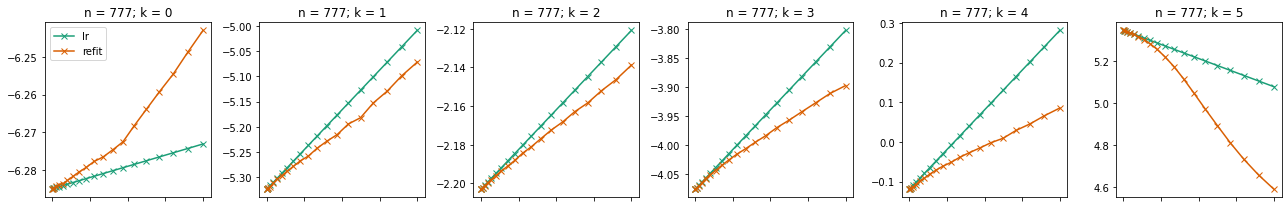

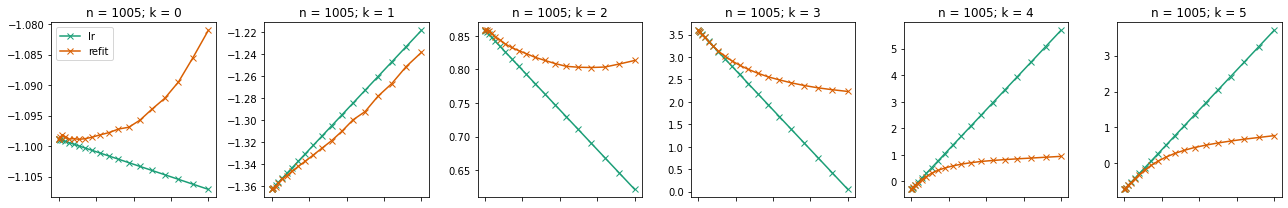

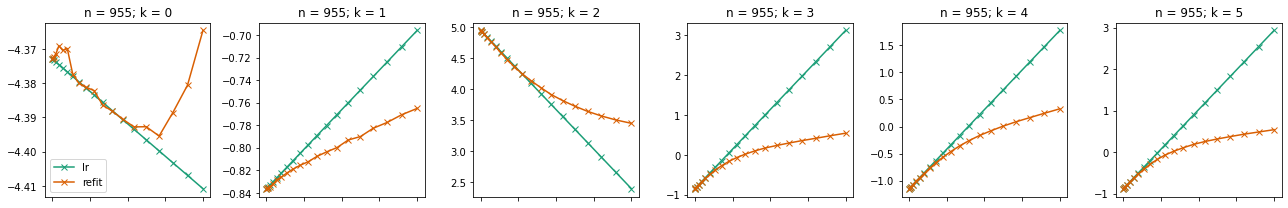

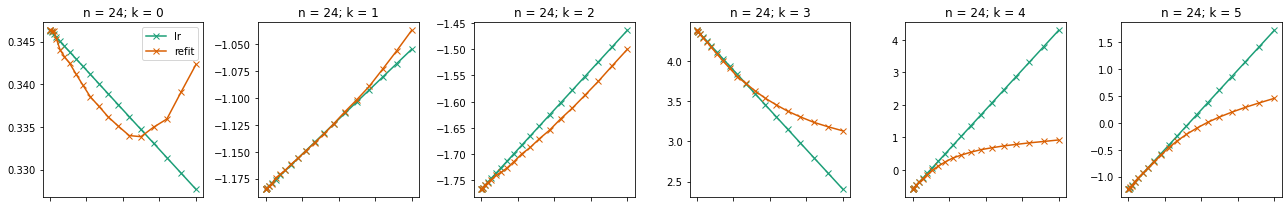

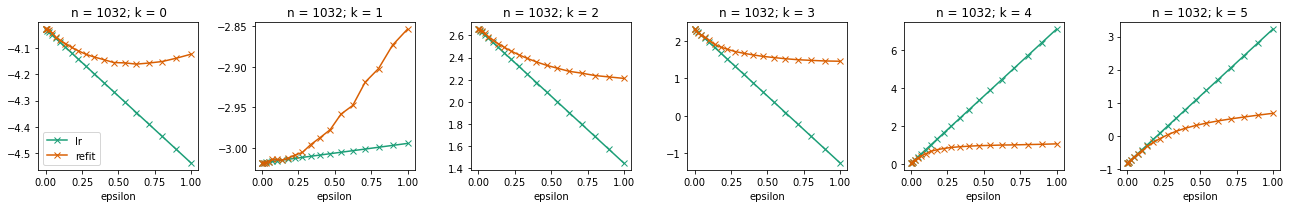

In [65]:
# subsample a few individuals
n_obs = e_ind_admix0.shape[0]
onp.random.seed(45353)
n_indx = onp.random.choice(n_obs, 5)
# n_indx = [1047]
k_indx = np.arange(6)


make_admix_trace_plots(lambda x : vb_params_paragami.fold(x, free = True)['ind_admix_params']['stick_means'],
                       n_indx, k_indx)

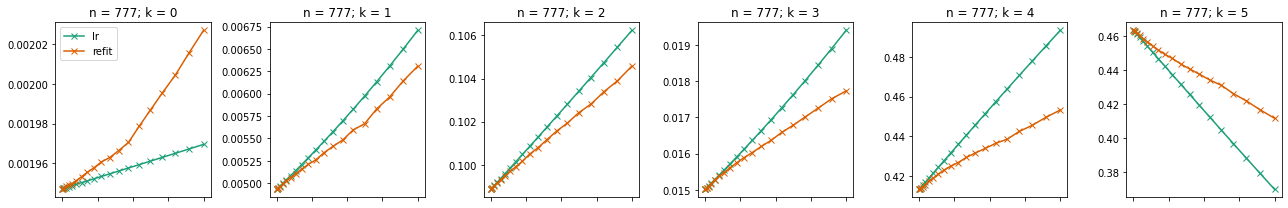

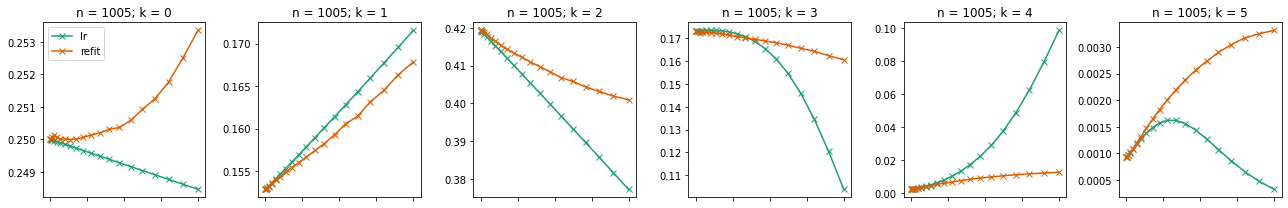

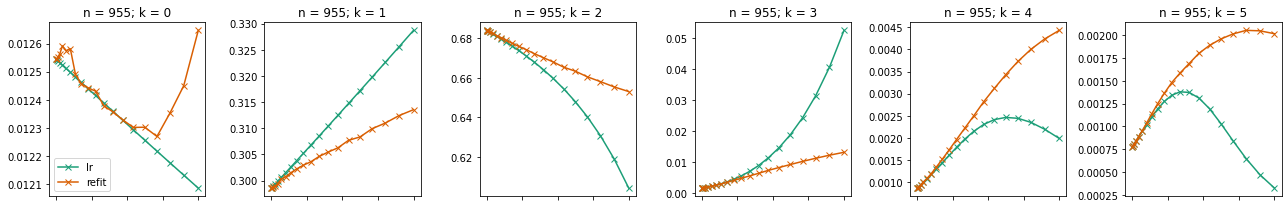

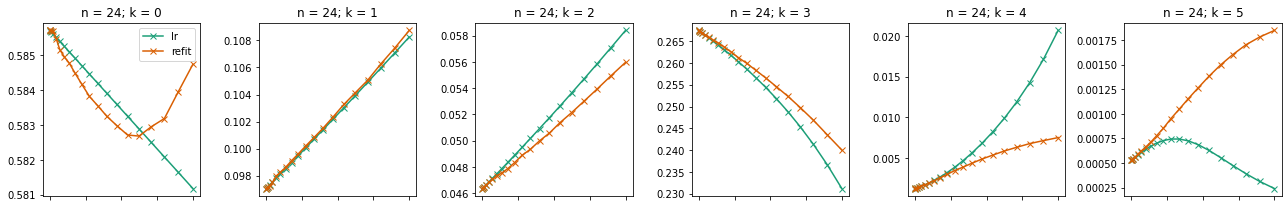

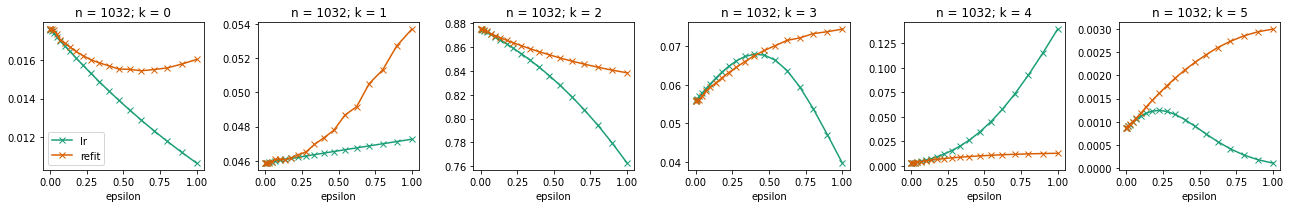

In [66]:
make_admix_trace_plots(get_e_ind_admix, n_indx, k_indx)

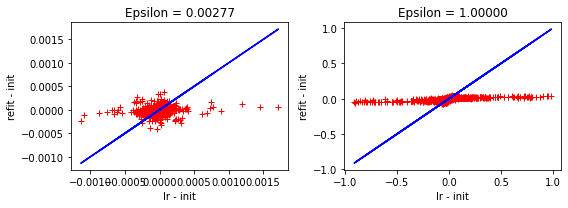

In [38]:
# refit vs. lr difference in individual admixtures
fig, ax = plt.subplots(1, 2, figsize = (8, 3))

# at smallest epsilon
e_ind_admix_refit = get_e_ind_admix(vb_refit_list[1])
e_ind_admix_lr = get_e_ind_admix(lr_list[1])

print_diff_plot(e_ind_admix_lr, 
                e_ind_admix_refit, 
                e_ind_admix0, 
                ax[0])

ax[0].set_title('Epsilon = {:.05f}'.format(epsilon_vec[1]))


# at epsilon = 1
e_ind_admix_refit = get_e_ind_admix(vb_refit_list[-1])
e_ind_admix_lr = get_e_ind_admix(lr_list[-1])

print_diff_plot(e_ind_admix_lr, 
                e_ind_admix_refit, 
                e_ind_admix0, 
                ax[1])
ax[1].set_title('Epsilon = {:.05f}'.format(epsilon_vec[-1]))



for i in range(2): 
    ax[i].set_xlabel('lr - init')
    ax[i].set_ylabel('refit - init')

fig.tight_layout(); 


In [39]:
np.argwhere(np.abs(e_ind_admix_lr - e_ind_admix0).max(1) > 0.2)

DeviceArray([[  14],
             [  23],
             [  35],
             [  37],
             [  54],
             [  63],
             [  68],
             [  78],
             [ 156],
             [ 195],
             [ 223],
             [ 308],
             [ 323],
             [ 359],
             [ 383],
             [ 388],
             [ 392],
             [ 396],
             [ 398],
             [ 414],
             [ 432],
             [ 444],
             [ 449],
             [ 454],
             [ 459],
             [ 460],
             [ 472],
             [ 499],
             [ 512],
             [ 516],
             [ 555],
             [ 562],
             [ 585],
             [ 586],
             [ 606],
             [ 612],
             [ 633],
             [ 635],
             [ 644],
             [ 649],
             [ 652],
             [ 653],
             [ 656],
             [ 658],
             [ 662],
             [ 677],
             [ 680],
             

# Plot cluster weights

In [40]:
# this is len(epsilon_vec) x n_obs x k_approx
e_ind_admix_lr_array = get_all_stats(lr_list, get_e_ind_admix)
e_ind_admix_refit_array = get_all_stats(vb_refit_list, get_e_ind_admix)

cluster_weights_lr = e_ind_admix_lr_array.sum(1)
cluster_weights_refit = e_ind_admix_refit_array.sum(1)

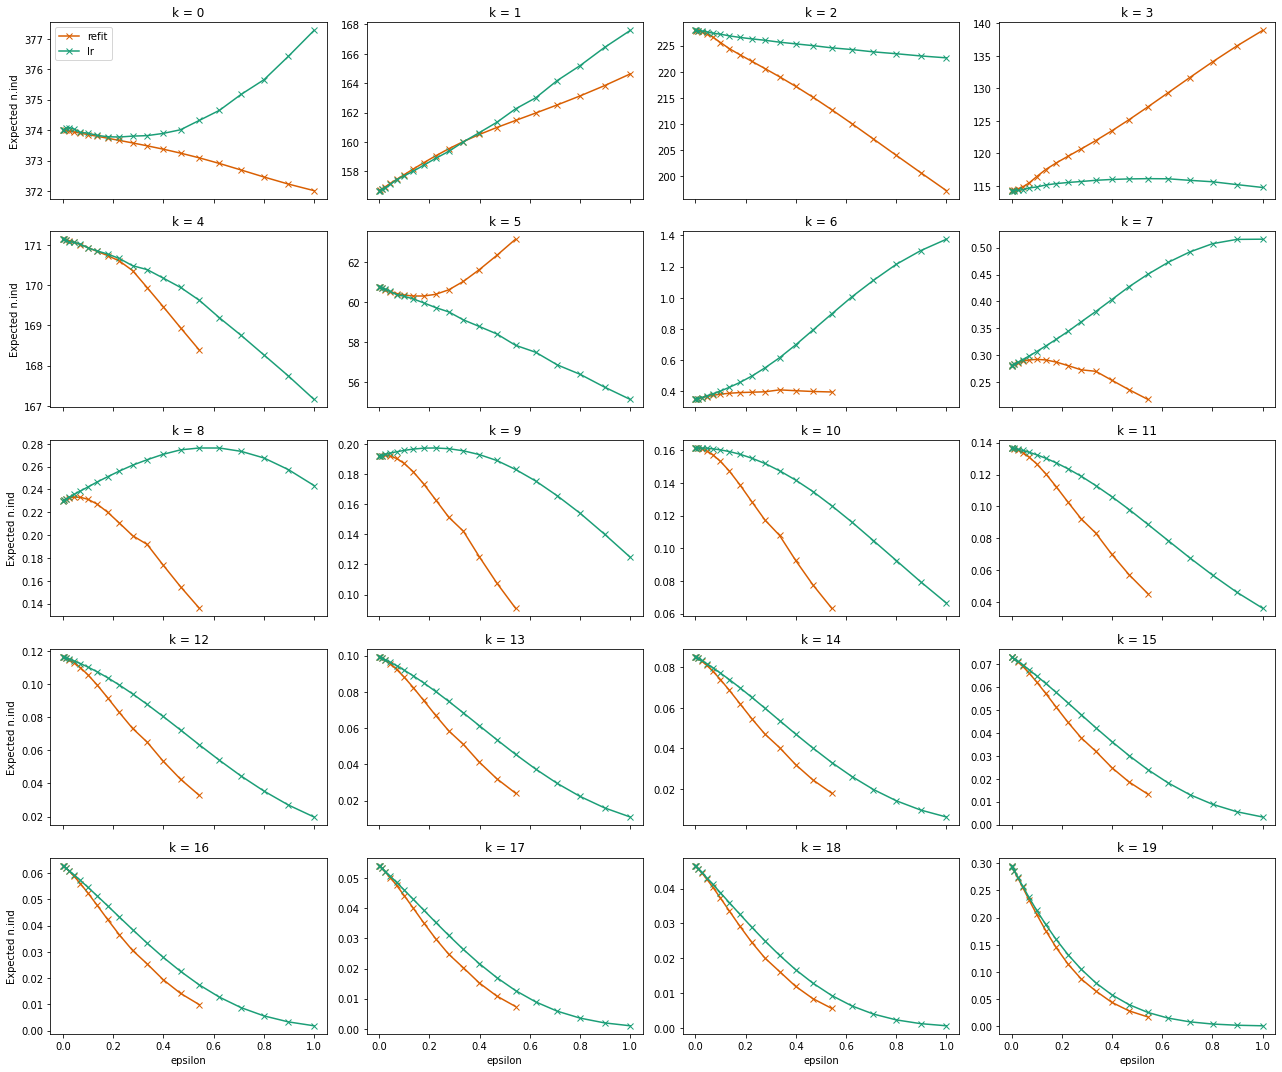

In [41]:
fig, ax = plt.subplots(5, 4,
                       figsize = (18, 15),
                       sharex = True)

k_approx = e_ind_admix0.shape[1]

for k in range(k_approx): 
    x0 = k // 4
    x1 = k % 4
    ax[x0, x1].plot(epsilon_vec,
                    cluster_weights_lr[:, k],
                    '-x', 
                    color = refit_color, 
                    label = 'refit')
    
    ax[x0, x1].plot(epsilon_vec,
                    cluster_weights_refit[:, k],
                    '-x', 
                    color = lr_color, 
                    label = 'lr')
    ax[x0, x1].set_title('k = {}'.format(k))
    if x0 == 4: 
        ax[x0, x1].set_xlabel('epsilon')
    if x1 == 0: 
        ax[x0, x1].set_ylabel('Expected n.ind')
        
    if k == 0: 
        ax[x0, x1].legend()

fig.tight_layout()

# Check out co-clustering

In [42]:
# sort based on initial fit
indx = cluster_admix_get_indx(e_ind_admix0)

def get_co_clustering_mat(ind_admix): 
    ind_admix_sorted = ind_admix # [indx]
    
    return np.dot(ind_admix_sorted, ind_admix_sorted.transpose())


def plot_co_clustering_mat(coclust_mat, ax, fig): 
    
    im = ax.matshow(coclust_mat, vmax = 1, vmin = 0, cmap = plt.get_cmap('Blues'))
    fig.colorbar(im, ax = ax)
    ax.set_xticks([])
    ax.set_yticks([])

### Plot co-clustering

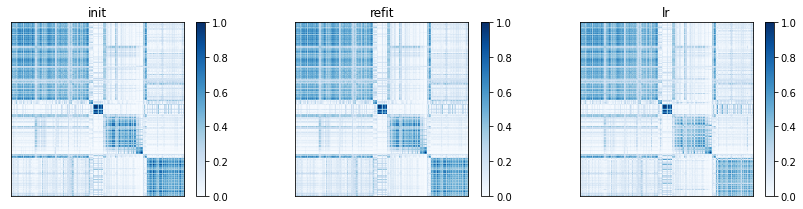

In [43]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3))
fig.tight_layout()

ax[0].set_title('init')
coclust_mat0 = get_co_clustering_mat(e_ind_admix0)
plot_co_clustering_mat(coclust_mat0, ax[0], fig)

ax[1].set_title('refit')
e_ind_admix_refit = get_e_ind_admix(vb_refit_list[-1])
coclust_mat_refit = get_co_clustering_mat(e_ind_admix_refit)
plot_co_clustering_mat(coclust_mat_refit, ax[1], fig)

ax[2].set_title('lr')
e_ind_admix_lr = get_e_ind_admix(lr_list[-1])
coclust_mat_lr = get_co_clustering_mat(e_ind_admix_lr)
plot_co_clustering_mat(coclust_mat_lr, ax[2], fig)

### Print differences in co-clustering

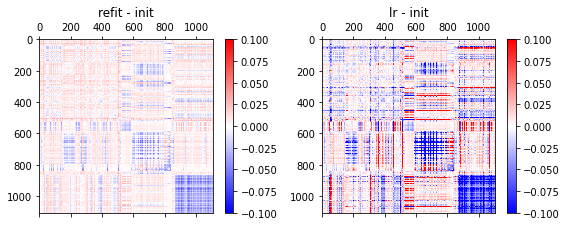

In [67]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3))
fig.tight_layout()

vmax = 0.1

ax[0].set_title('refit - init')
im0 = ax[0].matshow(coclust_mat_refit - coclust_mat0, 
                    cmap = plt.get_cmap('bwr'), 
                    vmax = vmax, 
                    vmin = -vmax)
fig.colorbar(im0, ax = ax[0])


ax[1].set_title('lr - init')
im0 = ax[1].matshow(coclust_mat_lr - coclust_mat0, 
                    cmap = plt.get_cmap('bwr'), 
                    vmax = vmax, 
                    vmin = -vmax)
fig.colorbar(im0, ax = ax[1])

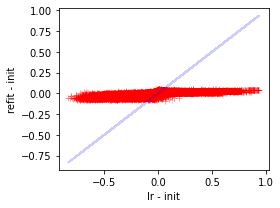

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (4, 3))

print_diff_plot(coclust_mat_lr.flatten(), 
                coclust_mat_refit.flatten(), 
                coclust_mat0.flatten(), 
                ax = ax, 
                alpha = 0.2)

ax.set_xlabel('lr - init')
ax.set_ylabel('refit - init')

fig.tight_layout(); 


# Study the population frequencies

In [46]:
def get_e_pop_freq(vb_free_params): 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    beta_params = vb_params_dict['pop_freq_beta_params']
    
    return beta_params[:, :, 0] / (beta_params[:, :, 0] + beta_params[:, :, 1])

In [47]:
# inferred population frequency at initial fit
e_pop_freq0 = get_e_pop_freq(vb_refit_list[0])

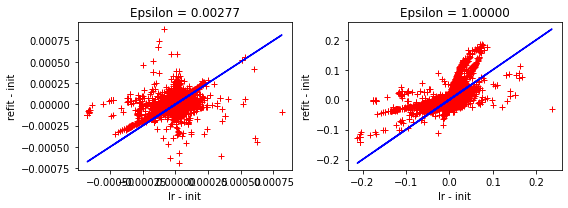

In [48]:
# refit vs. lr difference in individual admixtures
fig, ax = plt.subplots(1, 2, figsize = (8, 3))

# at smallest epsilon
e_pop_freq_refit = get_e_pop_freq(vb_refit_list[1])
e_pop_freq_lr = get_e_pop_freq(lr_list[1])

print_diff_plot(e_pop_freq_lr, 
                e_pop_freq_refit, 
                e_pop_freq0, 
                ax[0])

ax[0].set_title('Epsilon = {:.05f}'.format(epsilon_vec[1]))


# at epsilon = 1
e_pop_freq_refit = get_e_pop_freq(vb_refit_list[-1])
e_pop_freq_lr = get_e_pop_freq(lr_list[-1])

print_diff_plot(e_pop_freq_lr, 
                e_pop_freq_refit, 
                e_pop_freq0, 
                ax[1])

ax[1].set_title('Epsilon = {:.05f}'.format(epsilon_vec[-1]))

for i in range(2): 
    ax[i].set_xlabel('lr - init')
    ax[i].set_ylabel('refit - init')

fig.tight_layout(); 


### For plotting centroids,  run PCA on population frequencies

In [49]:
import sklearn
pca_model = sklearn.decomposition.PCA(n_components = 2)
pca_model.fit(e_pop_freq0.transpose())

PCA(n_components=2)

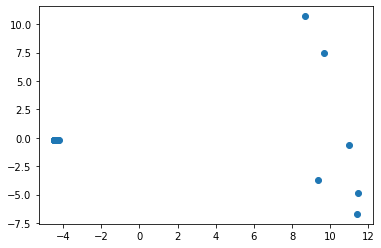

In [50]:
# Plot initial centroids
e_pop_freq0_transformed = pca_model.transform(e_pop_freq0.transpose())
plt.scatter(e_pop_freq0_transformed[:, 0], 
            e_pop_freq0_transformed[:, 1])

In [51]:
e_pop_freq0_transformed.shape

(20, 2)

### Plot centroids across epsilon

In [52]:
def get_pca_centroids_from_free(vb_free):
    
    # get expected population frequencies 
    e_pop_freq = get_e_pop_freq(vb_free)
    
    # return pca centroids
    return pca_model.transform(e_pop_freq.transpose())

In [53]:
# this is len(epsilon_vec) x k_approx x n_pca_components
centroids_refit_array = get_all_stats(vb_refit_list, get_pca_centroids_from_free)
centroids_lr_array = get_all_stats(lr_list, get_pca_centroids_from_free)

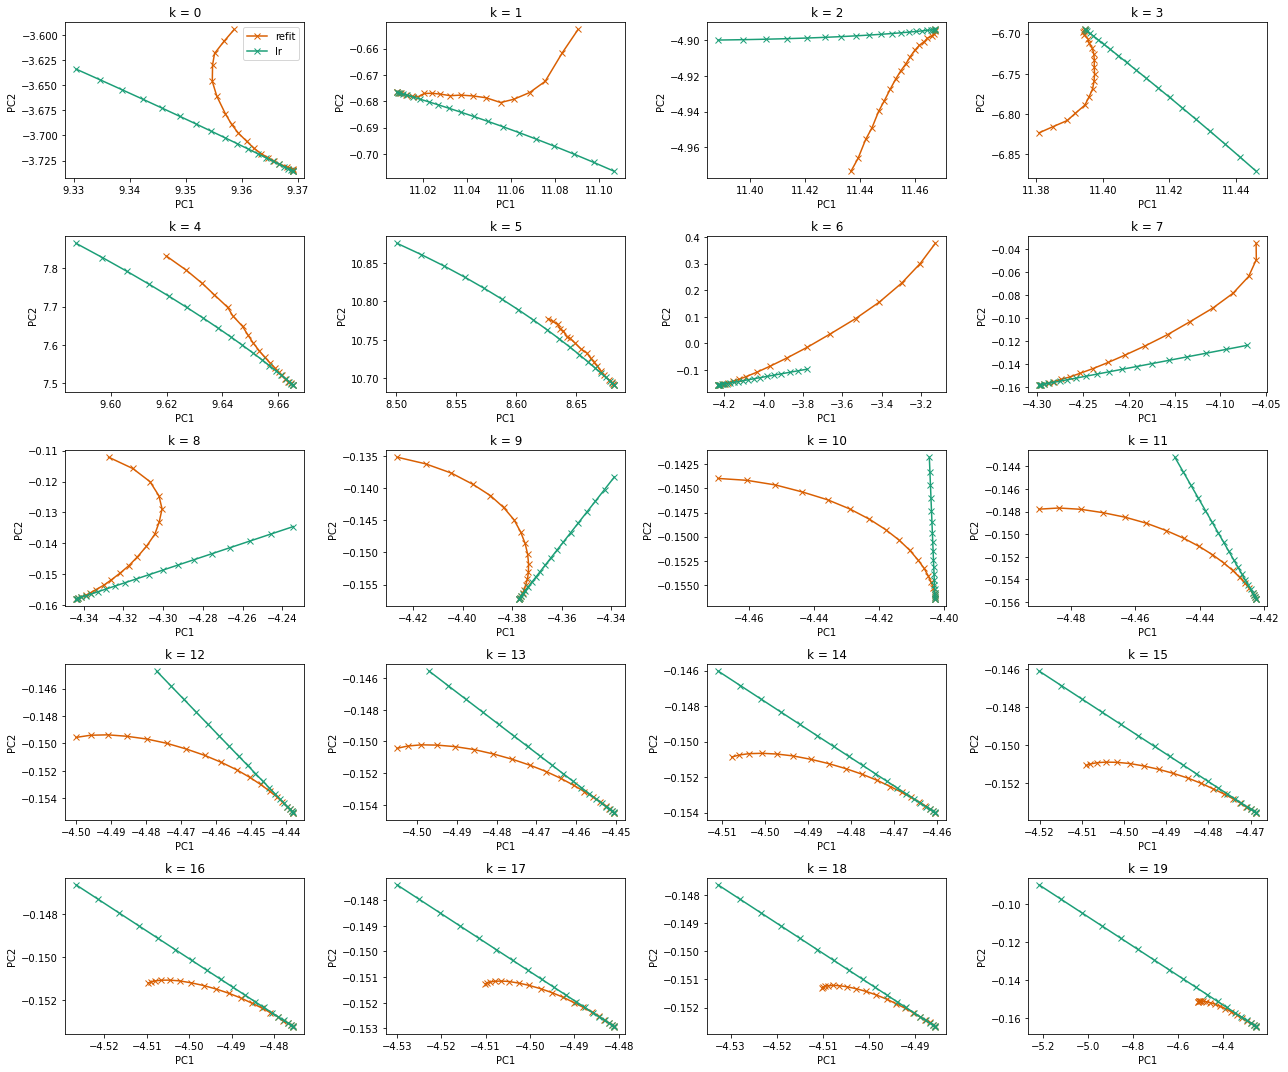

In [54]:
fig, ax = plt.subplots(5, 4,
                       figsize = (18, 15))

k_approx = e_ind_admix0.shape[1]

for k in range(k_approx): 
    x0 = k // 4
    x1 = k % 4
    
    ax[x0, x1].plot(centroids_refit_array[:, k, 0], 
                    centroids_refit_array[:, k, 1], 
                    '-x', 
                    color = refit_color, 
                    label = 'refit')
    
    ax[x0, x1].plot(centroids_lr_array[:, k, 0], 
                    centroids_lr_array[:, k, 1], 
                    '-x', 
                    color = lr_color, 
                    label = 'lr')
    
    ax[x0, x1].set_title('k = {}'.format(k))
    ax[x0, x1].set_ylabel('PC2')
    ax[x0, x1].set_xlabel('PC1')

ax[0, 0].legend()
fig.tight_layout(); 

In [55]:
def get_cosine_sim_from_vb_free(vb_free): 
    
    # get expected population frequencies 
    e_pop_freq = get_e_pop_freq(vb_free)
    
    e_pop_freq -= e_pop_freq.mean(1, keepdims = True)
    
    # compute cosine similarity
    norm_const = np.sqrt(np.sum(e_pop_freq**2, axis = 0, keepdims = True))
    
    e_pop_freq = (e_pop_freq / norm_const)
    
    return np.dot(e_pop_freq.transpose(), e_pop_freq)

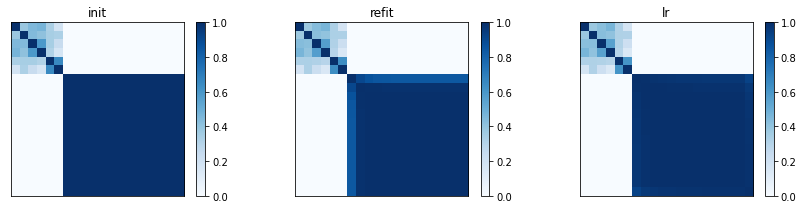

In [56]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3))
fig.tight_layout()

ax[0].set_title('init')
plot_co_clustering_mat(get_cosine_sim_from_vb_free(vb_refit_list[0]), ax[0], fig)

ax[1].set_title('refit')
plot_co_clustering_mat(get_cosine_sim_from_vb_free(vb_refit_list[-1]), ax[1], fig)


ax[2].set_title('lr')
e_pop_freq_lr = get_e_pop_freq(lr_list[-1])
plot_co_clustering_mat(get_cosine_sim_from_vb_free(lr_list[-1]), ax[2], fig)


In [57]:
init_cos_sim = get_cosine_sim_from_vb_free(vb_refit_list[0])
refit_cos_sim = get_cosine_sim_from_vb_free(vb_refit_list[-1])
lr_cos_sim = get_cosine_sim_from_vb_free(lr_list[-1])

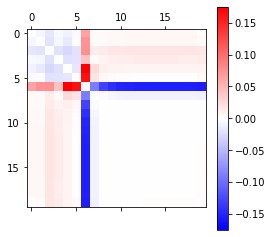

In [58]:
diff = refit_cos_sim - init_cos_sim
diff2 = lr_cos_sim - init_cos_sim

vmax = max(np.abs(diff).max(), np.abs(diff2).max())

plt.matshow(diff, 
            vmax = vmax,
            vmin = -vmax, 
            cmap = plt.get_cmap('bwr'))
plt.colorbar()

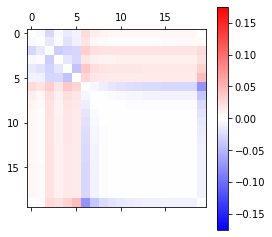

In [59]:
plt.matshow(diff2, 
            vmax = vmax, 
            vmin = -vmax, 
            cmap = plt.get_cmap('bwr'))
plt.colorbar()

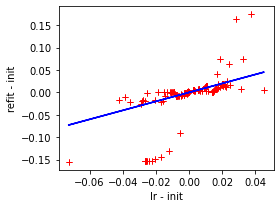

In [60]:
fig, ax = plt.subplots(1, 1, figsize = (4, 3))


init_cos_sim = get_cosine_sim_from_vb_free(vb_refit_list[0])
refit_cos_sim = get_cosine_sim_from_vb_free(vb_refit_list[-1])
lr_cos_sim = get_cosine_sim_from_vb_free(lr_list[-1])

print_diff_plot(lr_cos_sim.flatten(), 
                refit_cos_sim.flatten(), 
                init_cos_sim.flatten(), 
                ax = ax)

ax.set_xlabel('lr - init')
ax.set_ylabel('refit - init')

fig.tight_layout(); 


### Trace plot of how first row of this similarity matrix changes across epsilon

In [61]:
# first dimension is of length epsilon_vec
cos_sim_refit_array = get_all_stats(vb_refit_list, get_cosine_sim_from_vb_free)
cos_sim_lr_array = get_all_stats(lr_list, get_cosine_sim_from_vb_free)

In [62]:
coclust_row = 0

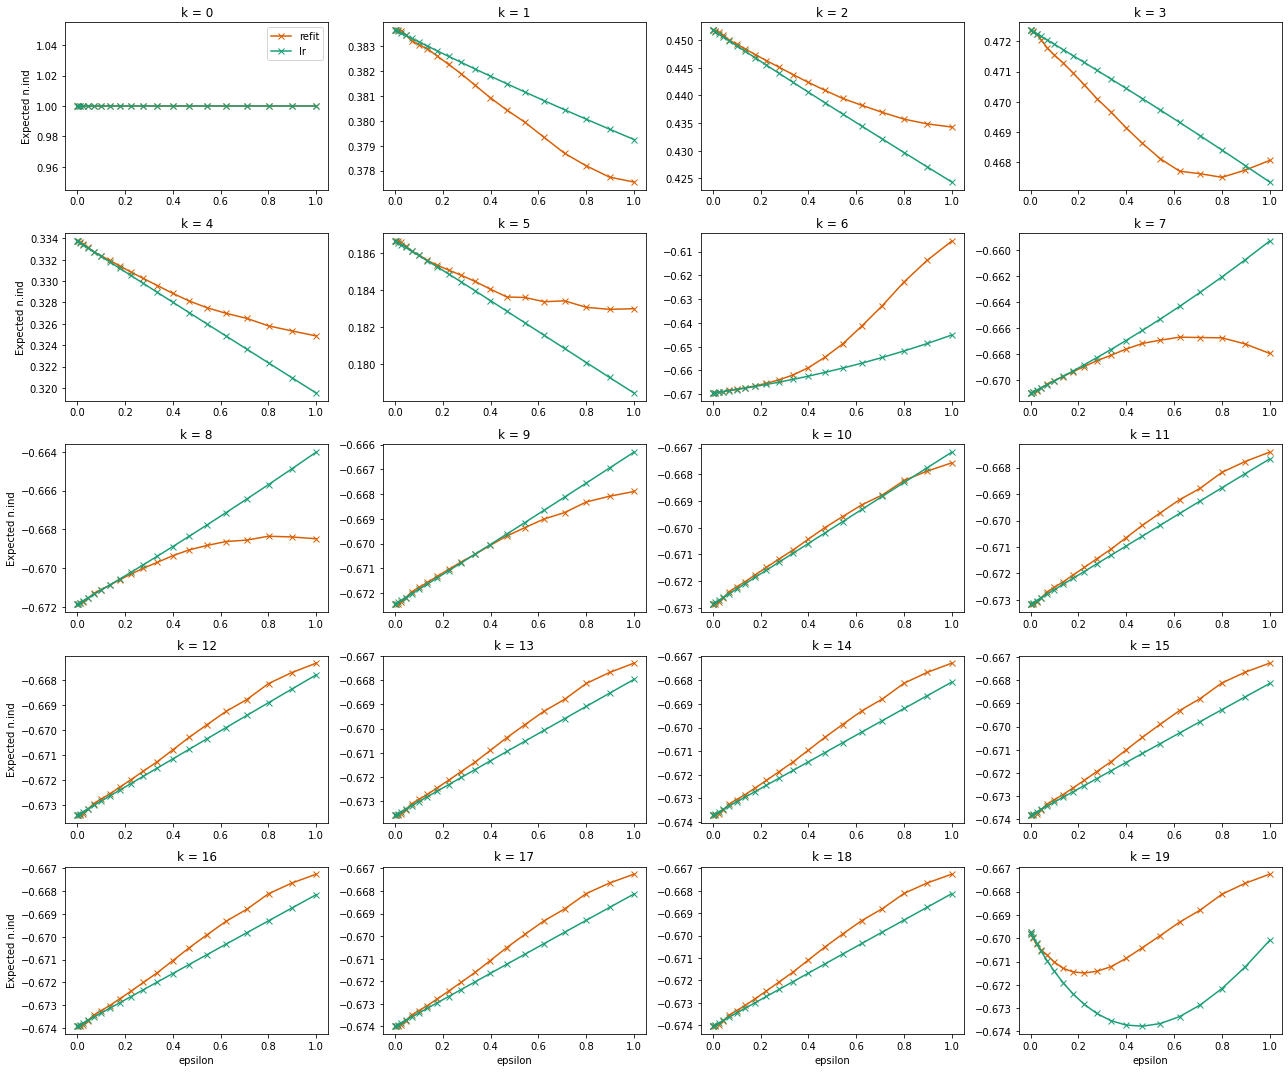

In [63]:
fig, ax = plt.subplots(5, 4, figsize = (18, 15))

k_approx = e_ind_admix0.shape[1]

for k in range(k_approx): 
    x0 = k // 4
    x1 = k % 4
    
    ax[x0, x1].plot(epsilon_vec, 
                    cos_sim_refit_array[:, k, coclust_row], 
                    '-x', 
                    color = refit_color, 
                    label = 'refit')
    
    ax[x0, x1].plot(epsilon_vec, 
                    cos_sim_lr_array[:, k, coclust_row], 
                    '-x', 
                    color = lr_color, 
                    label = 'lr')
    ax[x0, x1].set_title('k = {}'.format(k))
    if x0 == 4: 
        ax[x0, x1].set_xlabel('epsilon')
    if x1 == 0: 
        ax[x0, x1].set_ylabel('Expected n.ind')
        
    if k == 0: 
        ax[x0, x1].legend()

ax[0, 0].legend()
fig.tight_layout(); 